In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
import os

# Data Preprocessing

In [3]:
def extractData(data, target_chords):
    # filtering only rows where atleast one target chord label is 1
    filtered_data = data[data[target_chords].sum(axis=1) > 0]
    
    # extracting filenames and their labels
    filtered_filenames = filtered_data['filename'].values
    filtered_labels = filtered_data[target_chords].values

    return filtered_filenames, filtered_labels

In [4]:
# function to zoom into the image
def zoom_image(image, zoom_factor=1.75):
    
    h, w, _ = image.shape
    center_x, center_y = w // 2, h // 2
    
    # calculating crop dimensions using the zoom factor
    crop_w, crop_h = int(w / (2 * zoom_factor)), int(h / (2 * zoom_factor))
    
    # making sure cropping dimensions are within the image boundaries
    x1, x2 = max(center_x - crop_w, 0), min(center_x + crop_w, w)
    y1, y2 = max(center_y - crop_h, 0), min(center_y + crop_h, h)
    
    cropped = image[y1:y2, x1:x2]
    
    # resizing the zoomed image back to the original dimensions
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    return zoomed

In [5]:
# function to process the images in a directory
def zoom_images_in_dict(filenames, image_dir, zoom_factor=1.75, output_dir=None):
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)  # create the output directory if it doesn't exist

    for idx, filename in enumerate(filenames):
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        
        if image is not None:
            
            zoomed_image = zoom_image(image, zoom_factor=zoom_factor)

            # if the output directory exists/is provided, store the images there or else rewrite the images in the image directory
            if output_dir:
                output_path = os.path.join(output_dir, filename)
                cv2.imwrite(output_path, zoomed_image)
            else:
                # verwrite the original image
                cv2.imwrite(image_path, zoomed_image)
        else:
            print(f"Could not read image: {filename}")

In [6]:
train_data = pd.read_csv('./chord_images/train/_classes.csv')
test_data = pd.read_csv('./chord_images/test/_classes.csv')
valid_data = pd.read_csv('./chord_images/valid/_classes.csv')

# defining target chords to filter
target_chords = [' G', ' C', ' D', ' F']

train_filenames, train_labels = extractData(train_data, target_chords)
test_filenames, test_labels = extractData(test_data, target_chords)
valid_filenames, valid_labels = extractData(valid_data, target_chords)

train_images_dir= './chord_images/train/images/'
test_images_dir= './chord_images/test/images/'
valid_images_dir= './chord_images/valid/images/'

In [7]:
# defining output directories 
train_output_dir = './chord_images/train/1.25_zoomed_images/'
test_output_dir = './chord_images/test/1.25_zoomed_images/'
valid_output_dir = './chord_images/valid/1.25_zoomed_images/'

In [58]:
# processing the images
zoom_images_in_dict(train_filenames, train_images_dir, zoom_factor=1.25, output_dir=train_output_dir)
zoom_images_in_dict(test_filenames, test_images_dir, zoom_factor=1.25, output_dir=test_output_dir)
zoom_images_in_dict(valid_filenames, valid_images_dir, zoom_factor=1.25, output_dir=valid_output_dir)

In [8]:
# Limiting to 400 samples/images per chord for training
balanced_train_filenames = []
balanced_train_labels = []

for i, chord in enumerate(target_chords):
    chord_indices = [idx for idx, label in enumerate(train_labels) if label[i] == 1]
    limited_indices = chord_indices[:400]
    balanced_train_filenames.extend(train_filenames[limited_indices])
    balanced_train_labels.extend(train_labels[limited_indices])

balanced_train_filenames = pd.Series(balanced_train_filenames)
balanced_train_labels = pd.DataFrame(balanced_train_labels, columns=target_chords)

# Check counts for each chord
print(balanced_train_labels.sum(axis=0))

 G    400
 C    400
 D    400
 F    400
dtype: int64


In [9]:
def preprocess_image(filepath, label, image_dir):
    # Combine the directory path and filename
    filepath = tf.strings.join([image_dir, filepath])
    # Load and preprocess the image
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)  # decode as RGB
    image = tf.image.resize(image, (384, 384))      # resize the image from 640x640 to 384x384
    image = image / 255.0                           # normalize pixel values 

    # Cast label to float32
    label = tf.cast(label, tf.float32)
    return image, label

def create_dataset(filenames, labels, image_dir, batch_size=32):
    # creating a TensorFlow dataset with the filnames, labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(lambda f, l: tf.py_function(
        func=preprocess_image,
        inp=[f, l, image_dir],
        Tout=[tf.float32, tf.float32]
    ))
    # Explicitly set shapes
    dataset = dataset.map(lambda img, lbl: (
        tf.ensure_shape(img, (384, 384, 3)),  
        tf.ensure_shape(lbl, (4,))          # label shape (4,) for one-hot encoding
    ))
    # Shuffle, batch, and prefetch the dataset
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [10]:
train_dataset = create_dataset(balanced_train_filenames, balanced_train_labels, train_output_dir)
valid_dataset = create_dataset(valid_filenames, valid_labels, valid_output_dir)
test_dataset = create_dataset(test_filenames, test_labels, test_output_dir)

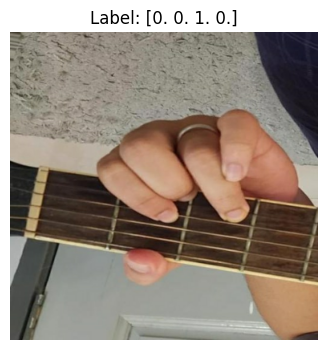

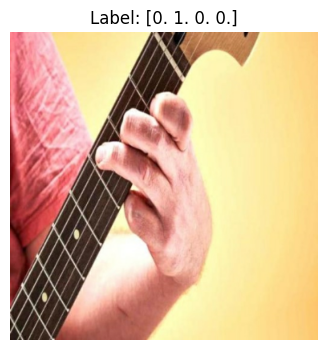

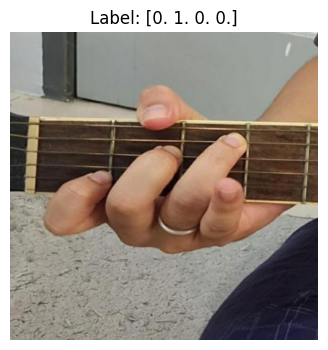

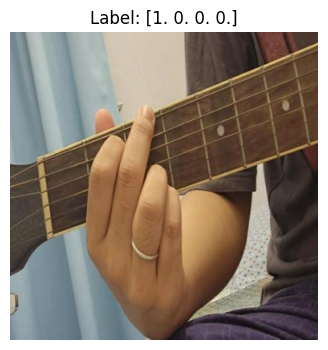

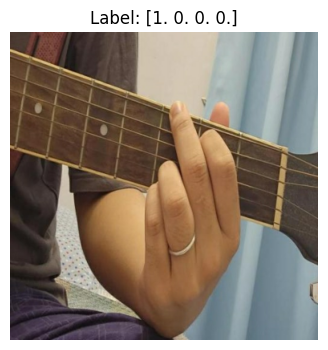

In [11]:
import matplotlib.pyplot as plt

# visualize a few images from the dataset
def visualize_dataset(dataset, num_images=5):
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(num_images):
            plt.figure(figsize=(4, 4))
            plt.imshow(images[i].numpy())  # convert the tensor to numpy array for visualization
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
            plt.show()

visualize_dataset(train_dataset, num_images=5)

# Model Initialization and Training 

In [55]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(384, 384, 3)), 
    tf.keras.layers.Conv2D(16, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax') 
])

In [56]:
model.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

In [57]:
model.fit(
   train_dataset,
   validation_data=valid_dataset,
   epochs=15
)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.3141 - loss: 1.7000 - val_accuracy: 0.1818 - val_loss: 1.2863
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3859 - loss: 1.2460 - val_accuracy: 0.2727 - val_loss: 1.2723
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6637 - loss: 0.8780 - val_accuracy: 0.6818 - val_loss: 1.1650
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8411 - loss: 0.4753 - val_accuracy: 0.6818 - val_loss: 1.2053
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9401 - loss: 0.2345 - val_accuracy: 0.8182 - val_loss: 0.8561
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9635 - loss: 0.1230 - val_accuracy: 0.6364 - val_loss: 1.7604
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9757 - loss: 0.0759 - val_accuracy: 0.6818 - val_loss: 1.7111
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9850 - loss: 0.0538 - val_accuracy: 0.8182 - val_loss:

In [58]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Optional: Get predictions for the test set
predictions = model.predict(test_dataset)

# Convert predictions to class indices
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Convert true labels to indices if one-hot encoded
true_labels = tf.argmax(tf.concat([y for _, y in test_dataset], axis=0), axis=1).numpy()

# Print some examples
for i in range(10):
    print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step - accuracy: 0.9500 - loss: 0.4132
Test Loss: 0.4132
Test Accuracy: 95.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
True label: 3, Predicted label: 1
True label: 3, Predicted label: 3
True label: 3, Predicted label: 0
True label: 0, Predicted label: 0
True label: 3, Predicted label: 3
True label: 0, Predicted label: 0
True label: 3, Predicted label: 3
True label: 0, Predicted label: 0
True label: 3, Predicted label: 3
True label: 0, Predicted label: 3


In [59]:
model.save('GCDF_chords_classification_model.keras')